In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_20newsgroups, load_files

import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('bank_train.csv')
labels = pd.read_csv('bank_train_target.csv', header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


$\quad$ Подавляющее большинство методов классификации и регрессии сформулированы в терминах евклидовых или метрических пространств, то есть подразумевают представление данных в виде вещественных векторов одинаковой размерности.
<br>$\quad$ В реальных данных, однако, не так редки категориальные признаки, принимающие дискретные значения, такие как да/нет или январь/февраль/.../декабрь. Обсудим то, как работать с такими данными, в частности с помощью линейных моделей.

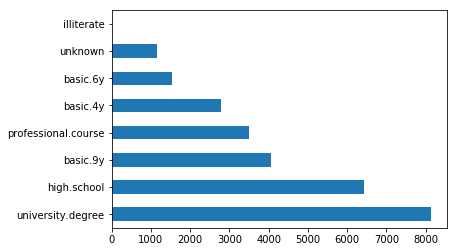

In [3]:
df['education'].value_counts().plot.barh();

Можно было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать university.degree в 0, а basic.9y в 1. Эту простую операцию приходится делать часто, поэтому в модуле preprocessing библиотеки sklearn именно для этой задачи реализован класс LabelEncoder.

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


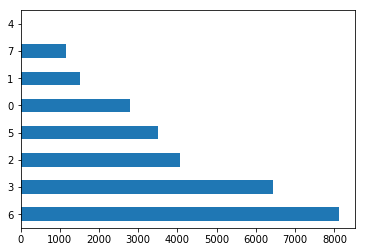

In [4]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()

print(dict(enumerate(label_encoder.classes_)))

In [5]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
    
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Основная проблема такого представления заключается в том, что числовой код создал евклидово представление для данных.

К примеру, нами неявным образом была введена алгебра над значениями работы – мы можем вычесть работу клиента 1 из работы клиента 2. Конечно же, эта операция не имеет никакого смысла. Но именно на этом основаны метрики близости объектов, что делает бессмысленным применение метода ближайшего соседа на данных в таком виде. Аналогичным образом, никакого смысла не будет иметь применение линейных моделей. 

Посмотрим, как на таких данных сработает логистическая регрессия и убедимся, что ничего хорошего не получается:

In [6]:
import warnings
warnings.filterwarnings('ignore')

def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    
    return classification_report(test_labels, logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6115
           1       0.75      0.00      0.01       784

   micro avg       0.89      0.89      0.89      6899
   macro avg       0.82      0.50      0.47      6899
weighted avg       0.87      0.89      0.83      6899



----
----
---

Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим другой метод, который называется One-Hot Encoding.

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1.

Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. <br>Однако в этом примере размер данных не является для нас проблемой, поэтому мы будем использовать "плотное" представление:

In [7]:
onehot_encoder = OneHotEncoder(sparse=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Мы получили 53 столбца — именно столько различных уникальных значений могут принимать категориальные столбцы исходной выборки. 

Преобразованные с помощью One-Hot Encoding данные начинают обретать смысл для линейной модели – точность по классу 1 (кто подтвердил кредит) составила 63%, полнота – 19%:

In [8]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6143
           1       0.65      0.17      0.26       756

   micro avg       0.90      0.90      0.90      6899
   macro avg       0.78      0.58      0.60      6899
weighted avg       0.88      0.90      0.87      6899



-----
---
---

Реальные данные могут оказаться гораздо более динамичными, и мы не всегда можем рассчитывать, что категориальные признаки не будут принимать новых значений. Все это сильно затрудняет использование уже обученных моделей на новых данных. Кроме того, LabelEncoder подразумевает предварительный анализ всей выборки и хранение построенных отображений в памяти, что затрудняет работу в режиме больших данных.


Для решения этих проблем существует более простой подход к векторизации категориальных признаков, основанный на хэшировании, известный как hashing trick.


Хэш-функции могут помочь нам в задаче поиска уникальных кодов для различных значений признака, к примеру:

In [9]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> 1970989430698161902
high.school -> -4052830460602535391
illiterate -> 7443125470986368461


Отрицательные и настолько большие по модулю значения нам не подойдут. Ограничим область значений хэш-функции:

In [10]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 2
high.school -> 9
illiterate -> 11


Представим, что у нас в выборке есть холостой студент, которому позвонили в понедельник, тогда его вектор признаков будет сформирован аналогично One-Hot Encoding, но в едином пространстве фиксированного размера для всех признаков:

In [11]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])

for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
    
hashing_example

job=student -> 5
marital=single -> 7
day_of_week=mon -> 21


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Стоит обратить внимание, что в этом примере хэшировались не только значения признаков, а пары название признака + значение признака. Это необходимо, чтобы разделить одинаковые значения разных признаков между собой.

Hashing trics - по сути, единственный подход к тому, чтобы работать с категориальными признаками, у которых много уникальных значений. Более того, эта техника себя хорошо зарекомендовала по результатами на практике.

-------
------
----

**Vowpal Wabbit (VW)** является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Реализовано хэширование признаков, и Vowpal Wabbit отлично подходит для работы с текстовыми данными.

Основным интерфейсом для работы с VW является shell. Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:


[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features


Namespace=String[:Value]


Features=(String[:Value] )*


где [] обозначает необязательные элементы, а (...)* означает повтор неопределенное число раз.


* **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
* **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
* **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
* **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
* **Features** являются непосредственно признаками объекта внутри Namespace. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1.

In [12]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='train')

Рассмотрим первый текстовый документ этой коллекции:

In [13]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов:

In [14]:
def to_vw_format(document, label=None):
    
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили rec.autos. Так мы построим модель, отличающую новости про автомобили от остальных.

In [15]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
                 else -1 for target in newsgroups['target']]

In [16]:
train_documents, test_documents, train_labels, test_labels = train_test_split(all_documents, all_targets, random_state=7)

with open('20news_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('20news_test.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Так как решаем задачу классификации, то зададим функцию потерь в значение hinge (линейный SVM). Построенную модель сохраним в соответствующий файл 20news_model.vw:

In [ ]:
!vw -d 20news_train.vw --loss_function hinge -f 20news_model.vw

Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p:

In [ ]:
!vw -i ../../data/news_data/20news_model.vw -t -d ../../data/news_data/20news_test.vw \
    -p ../../data/news_data/20news_test_predictions.txt

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

In [ ]:
with open('20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

------
-----
----

In [ ]:
path = '.../aclImdb'
reviews_train = load_files(os.path.join(path, 'train'))

text_train, y_train = reviews_train.data, reviews_train.target

In [ ]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

In [ ]:
reviews_test = load_files(os.path.join(path, 'test'))

text_test, y_test = reviews_test.data, reviews_train.target

In [ ]:
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Будем использовать ранее написанную функцию to_vw_format. Подготовим обучающую (movie_reviews_train.vw), отложенную (movie_reviews_valid.vw) и тестовую (movie_reviews_test.vw) выборки для Vowpal Wabbit. 70% исходной обучающей выборки оставим под обучение, 30% – под отложенную выборку:

In [ ]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

with open('movie_reviews_train.vw', 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('movie_reviews_valid.vw', 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('movie_reviews_test.vw', 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

Обучим модель Vowpal Wabbit:

In [ ]:
!vw -d movie_reviews_train.vw --loss_function hinge -f movie_reviews_model.vw --quiet

Сделаем прогноз для отложенной выборки:

In [ ]:
!vw -i movie_reviews_model.vw -t -d movie_reviews_valid.vw -p movie_valid_pred.txt --quiet

Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной:

In [ ]:
with open('movie_valid_pred.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
    
print("Accuracy: {}".format(round(accuracy_score(valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

In [ ]:
!vw -i movie_reviews_model.vw -t -d movie_reviews_test.vw -p movie_test_pred.txt --quiet

In [ ]:
with open('movie_test_pred.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
    
print("Accuracy: {}".format(round(accuracy_score(y_test, [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Попробуем улучшить прогноз за счет задействования биграмм:

In [ ]:
!vw -d movie_reviews_train.vw --loss_function hinge --ngram 2 -f movie_reviews_model2.vw --quiet

In [ ]:
!vw -i movie_reviews_model2.vw -t -d movie_reviews_valid.vw -p movie_valid_pred2.txt --quiet

In [ ]:
with open('movie_valid_pred2.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
    
print("Accuracy: {}".format(round(accuracy_score(valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

In [ ]:
!vw -i movie_reviews_model2.vw -t -d movie_reviews_test.vw -p movie_test_pred2.txt --quiet

In [ ]:
with open('movie_test_pred2.txt') as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
    
print("Accuracy: {}".format(round(accuracy_score(y_test, [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))